In [1]:
import re
from datetime import datetime
from typing import List, Dict, Any, Optional, Union
import pandas as pd
import matplotlib.pyplot as plt
import json
import os

%matplotlib inline
plt.rcParams["figure.figsize"] = (10,5)

In [24]:
class AccountError(Exception):
    pass

class Account:
    _account_counter = 1000

    def __init__(self, account_holder: str, balance: float = 0.0):
        self._validate_name(account_holder)
        if balance < 0:
            raise AccountError("Initial balance cannot be negative.")
        Account._account_counter += 1
        self.holder = account_holder
        self.account_number = f"ACC-{Account._account_counter:04d}"
        self._balance = float(balance)
        self.operations_history = []
        if self._balance > 0:
            self._record_operation('deposit', self._balance, status='success', note='initial_balance')

    @staticmethod
    def _validate_name(name: str):
        if not isinstance(name, str):
            raise AccountError("Account holder name must be a string.")
        name = name.strip()
        pattern = r'^[A-ZА-ЯЁ][a-zа-яё]+ [A-ZА-ЯЁ][a-zа-яё]+$'
        if not re.match(pattern, name, flags=re.UNICODE):
            raise AccountError("Account holder name must be in format 'Firstname Lastname' with capitalized names.")

    def _now(self):
        return datetime.now()

    def _record_operation(self, op_type, amount, status='success', note=None):
        self.operations_history.append({
            'type': op_type,
            'amount': float(amount),
            'datetime': self._now(),
            'balance_after': self._balance,
            'status': status,
            'note': note
        })

    def deposit(self, amount):
        if amount <= 0:
            raise AccountError("Deposit amount must be positive.")
        self._balance += float(amount)
        self._record_operation('deposit', amount)

    def withdraw(self, amount):
        if amount <= 0:
            raise AccountError("Withdraw amount must be positive.")
        if amount > self._balance:
            self._record_operation('withdraw', amount, status='fail', note='insufficient_funds')
            return False
        self._balance -= float(amount)
        self._record_operation('withdraw', amount)
        return True

    def get_balance(self):
        return self._balance
    def clean_history(self, records: list, allowed_types: list):
        """Проверка и очистка списка операций."""
        clean = []
        for rec in records:
            try:
                if not isinstance(rec, dict):
                    continue
                op_type = rec.get('type')
                if op_type not in allowed_types:
                    continue
                amount = rec.get('amount')
                if amount is None:
                    continue
                try:
                    amount_v = float(amount)
                except Exception:
                    continue
                if amount_v <= 0:
                    continue
                dt = rec.get('datetime')
                if isinstance(dt, str):
                    try:
                        dt = pd.to_datetime(dt)
                    except Exception:
                        continue
                elif not isinstance(dt, (datetime, pd.Timestamp)):
                    continue
                holder = rec.get('holder')
                if holder is not None and holder != self.holder:
                    continue
                clean.append({
                    'type': op_type,
                    'amount': amount_v,
                    'datetime': pd.to_datetime(dt),
                    'status': 'success'
                })
            except Exception:
                continue
        return clean

    def load_history_from_file(self, filepath: str, allowed_types: list = None):
        """Загрузка и применение операций из CSV или JSON."""
        if allowed_types is None:
            allowed_types = ['deposit', 'withdraw', 'interest']
        ext = os.path.splitext(filepath)[1].lower()
        if ext == '.csv':
            df = pd.read_csv(filepath)
            raw = df.to_dict(orient='records')
        elif ext == '.json':
            with open(filepath, 'r', encoding='utf-8') as f:
                raw = json.load(f)
        else:
            raise AccountError("Поддерживаются только .csv и .json")

        clean = self.clean_history(raw, allowed_types)
        applied = 0
        for rec in sorted(clean, key=lambda x: x['datetime']):
            typ, amt = rec['type'], rec['amount']
            if typ == 'deposit':
                self._balance += amt
                self._record_operation('deposit', amt, note='loaded_from_file')
                applied += 1
            elif typ == 'withdraw':
                if amt <= self._balance:
                    self._balance -= amt
                    self._record_operation('withdraw', amt, note='loaded_from_file')
                    applied += 1
                else:
                    self._record_operation('withdraw', amt, status='fail', note='insufficient_funds_from_file')
            elif typ == 'interest':
                self._balance += amt
                self._record_operation('interest', amt, note='loaded_from_file')
                applied += 1
        return applied    

In [15]:
class CheckingAccount(Account):
    account_type = 'checking'

    def __init__(self, account_holder: str, balance: float = 0.0):
        super().__init__(account_holder, balance=balance)

class SavingsAccount(Account):
    account_type = 'savings'

    def __init__(self, account_holder: str, balance: float = 0.0):
        super().__init__(account_holder, balance=balance)

    def apply_interest(self, rate: float):
        if not isinstance(rate, (int,float)):
            raise AccountError("Rate must be a number")
        if rate < 0:
            raise AccountError("Rate cannot be negative")
        interest_amount = self._balance * (rate / 100.0)
        if interest_amount != 0:
            self._balance += interest_amount
            self._record_operation('interest', interest_amount, note=f'{rate}% interest')
        return interest_amount

    def withdraw(self, amount: float):
        max_allowed = 0.5 * self._balance
        if amount > max_allowed:
            self._record_operation('withdraw', amount, status='fail', note='exceeds_50_percent_limit')
            return False
        return super().withdraw(amount)

In [16]:
acc1 = CheckingAccount("Иван Иванов", balance=1000.0)
acc2 = SavingsAccount("Anna Smith", balance=500.0)

print("acc1:", acc1.account_number, acc1.get_balance())
print("acc2:", acc2.account_number, acc2.get_balance())

acc1: ACC-1001 1000.0
acc2: ACC-1002 500.0


In [28]:
# Для acc1 (обычный счёт)
acc1.deposit(250)        # Пополняем на 250
acc1.withdraw(100)       # Снимаем 100
res = acc1.withdraw(2000) # Пытаемся снять слишком много (должно вернуть False)

print("acc1 баланс:", acc1.get_balance())
print("Результат попытки снять 2000:", res)

# Для acc2 (накопительный счёт)
res1 = acc2.withdraw(100)   # можно (<=50%)
res2 = acc2.withdraw(200)   # скорее всего нельзя (>50% оставшегося)
print("Результаты снятия:", res1, res2)
print("Баланс до процентов:", acc2.get_balance())

# Добавляем проценты
interest = acc2.apply_interest(7)
print("Начисленные проценты:", interest)
print("Баланс после процентов:", acc2.get_balance())

acc1 баланс: 500.0
Результат попытки снять 2000: False
Результаты снятия: True False
Баланс до процентов: 114.0
Начисленные проценты: 7.98
Баланс после процентов: 121.98


In [18]:
# История операций в виде таблицы
df1 = pd.DataFrame(acc1.operations_history)
df2 = pd.DataFrame(acc2.operations_history)

print("История acc1:")
display(df1)

print("История acc2:")
display(df2)

История acc1:


,type,amount,datetime,balance_after,status,note
0,deposit,1000.0,2025-11-07 11:38:10.116084,1000.0,success,initial_balance
1,deposit,250.0,2025-11-07 11:38:11.683106,1250.0,success,None
2,withdraw,100.0,2025-11-07 11:38:11.683207,1150.0,success,None
3,withdraw,2000.0,2025-11-07 11:38:11.683300,1150.0,fail,insufficient_funds


История acc2:


,type,amount,datetime,balance_after,status,note
0,deposit,500.0,2025-11-07 11:38:10.116388,500.0,success,initial_balance
1,withdraw,100.0,2025-11-07 11:38:11.683724,400.0,success,None
2,withdraw,200.0,2025-11-07 11:38:11.683807,200.0,success,None
3,interest,14.0,2025-11-07 11:38:11.684120,214.0,success,7% interest


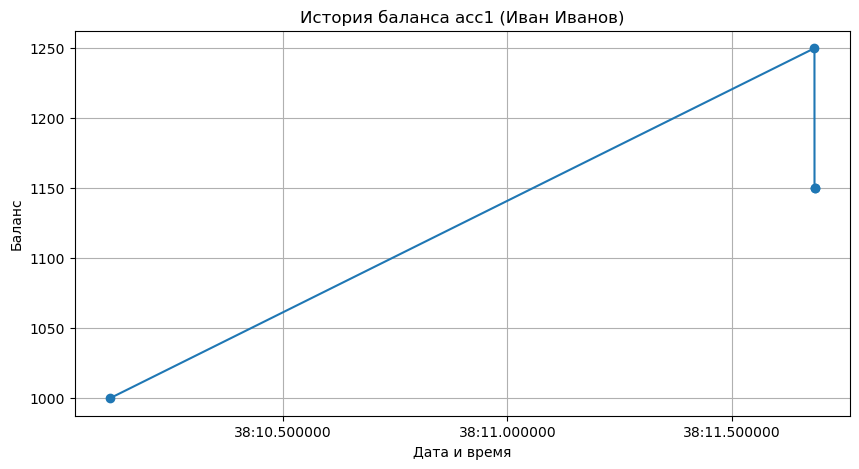

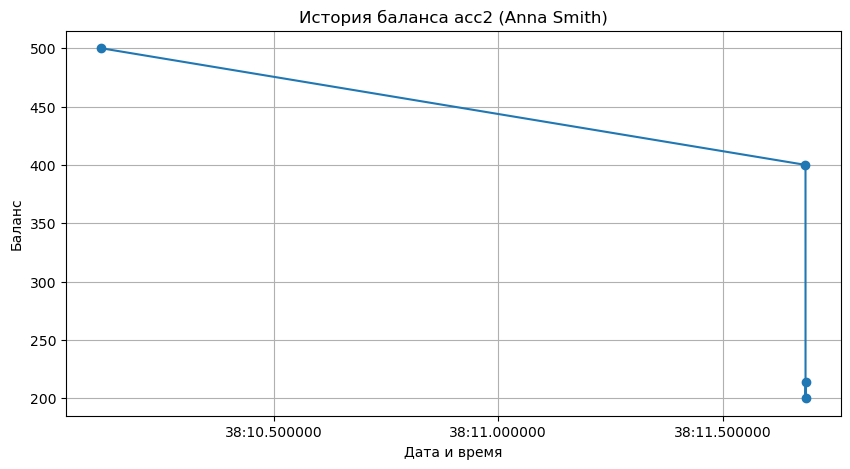

In [27]:
# график изменения баланса для acc1
plt.figure()
plt.plot(df1["datetime"], df1["balance_after"], marker='o')
plt.title("История баланса acc1 (Иван Иванов)")
plt.xlabel("Дата и время")
plt.ylabel("Баланс")
plt.grid(True)
plt.show()

# Для acc2
plt.figure()
plt.plot(df2["datetime"], df2["balance_after"], marker='o')
plt.title("История баланса acc2 (Anna Smith)")
plt.xlabel("Дата и время")
plt.ylabel("Баланс")
plt.grid(True)
plt.show()

In [21]:
# Самые крупные операции для acc1
df_top = pd.DataFrame(sorted(acc1.operations_history, key=lambda x: x["amount"], reverse=True)[:5])
display(df_top)

,type,amount,datetime,balance_after,status,note
0,withdraw,2000.0,2025-11-07 11:38:11.683300,1150.0,fail,insufficient_funds
1,deposit,1000.0,2025-11-07 11:38:10.116084,1000.0,success,initial_balance
2,deposit,250.0,2025-11-07 11:38:11.683106,1250.0,success,None
3,withdraw,100.0,2025-11-07 11:38:11.683207,1150.0,success,None


In [26]:
# пример "грязных" данных
sample_records = [
    {'type':'deposit','amount':'300','datetime':'2025-10-01 10:00:00','holder':'Иван Иванов'},
    {'type':'withdraw','amount':-50,'datetime':'2025-10-02 11:00','holder':'Иван Иванов'},
    {'type':'withdraw','amount':'1000','datetime':'2025-10-03 12:00','holder':'Иван Иванов'},
    {'type':'interest','amount':'5','datetime':'2025-10-04 09:00','holder':'Иван Иванов'},
    {'type':'deposit','amount':'abc','datetime':'2025-10-05 09:00','holder':'Иван Иванов'},
    {'type':'transfer','amount':'50','datetime':'2025-10-06 09:00','holder':'Иван Иванов'},
    {'type':'withdraw','amount':'50','datetime':'bad-date','holder':'Иван Иванов'},
    {'type':'deposit','amount':'200','datetime':'2025-10-07 09:00','holder':'Другой Человек'}
]

# CSV и JSON
pd.DataFrame(sample_records).to_csv('transactions_dirty.csv', index=False, encoding='utf-8-sig')
import json
with open('transactions_dirty.json', 'w', encoding='utf-8') as f:
    json.dump(sample_records, f, ensure_ascii=False, indent=2)

print("Файлы сохранены: transactions_dirty.csv и transactions_dirty.json")

Файлы сохранены: transactions_dirty.csv и transactions_dirty.json


In [25]:
# Проверка загрузки и очистки данных из файлов
applied_csv = acc1.load_history_from_file('transactions_dirty.csv', allowed_types=['deposit','withdraw'])
applied_json = acc1.load_history_from_file('transactions_dirty.json', allowed_types=['deposit','withdraw'])

print(f"Загружено операций из CSV: {applied_csv}")
print(f"Загружено операций из JSON: {applied_json}")
print("Текущий баланс acc1:", acc1.get_balance())

# последние операции после загрузки
display(pd.DataFrame(acc1.operations_history).tail(10))

Загружено операций из CSV: 2
Загружено операций из JSON: 1
Текущий баланс acc1: 350.0


,type,amount,datetime,balance_after,status,note
2,withdraw,100.0,2025-11-07 11:38:11.683207,1150.0,success,None
3,withdraw,2000.0,2025-11-07 11:38:11.683300,1150.0,fail,insufficient_funds
4,deposit,300.0,2025-11-07 11:39:05.323121,1450.0,success,loaded_from_file
5,withdraw,1000.0,2025-11-07 11:39:05.323134,450.0,success,loaded_from_file
6,deposit,300.0,2025-11-07 11:39:05.339095,750.0,success,loaded_from_file
7,withdraw,1000.0,2025-11-07 11:39:05.339104,750.0,fail,insufficient_funds_from_file
8,deposit,300.0,2025-11-07 11:45:56.460326,1050.0,success,loaded_from_file
9,withdraw,1000.0,2025-11-07 11:45:56.460334,50.0,success,loaded_from_file
10,deposit,300.0,2025-11-07 11:45:56.465616,350.0,success,loaded_from_file
11,withdraw,1000.0,2025-11-07 11:45:56.465625,350.0,fail,insufficient_funds_from_file
